# Optimization of a State-to-State Transfer in a Two-Level-System

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions
pi = np.pi
sqrt = np.sqrt
basis = qutip.basis
tensor = qutip.tensor
coherent = qutip.coherent

krotov           0.3.0
numpy            1.15.4
matplotlib       3.0.2
qutip            4.3.1
scipy            1.2.0
matplotlib.pylab 1.15.4
CPython 3.7.2
IPython 7.2.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$
The purpose of this example is not to solve an especially interesting physical
problem but to give a rather simple example of how the package can be used in
order to solve an optimization problem.

## Define the Hamiltonian

In the
following the Hamiltonian, guess field and
states are defined.

The Hamiltonian
$\op{H}_{0} = - \omega \op{\sigma}_{z}$
represents a
simple qubit with energy
level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control
field
$\epsilon(t)$ is assumed to couple via
the
Hamiltonian $\op{H}_{1}(t) =
\epsilon(t) \op{\sigma}_{x}$ to the qubit,
i.e., the control
field effectively
drives
transitions between both qubit
states. For now, we initialize the control
field as constant.

In [2]:
N = 12
α = 2

# Plotting functions

In [3]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

def plot_system(ψ):
    bl = qutip.Bloch()
    bl.add_states(ψ.ptrace(0))
    bl.show()
    qutip.visualization.plot_wigner_fock_distribution(ψ.ptrace(1))
def plot_resonator(ψ):
    fig, ax = plt.subplots(1,len(ψ), figsize=(3*len(ψ),3))
    for (ϕ, axis) in zip(ψ, ax):
        qutip.visualization.plot_wigner(ϕ.ptrace(1), fig=fig, ax=axis, alpha_max = 2*α)
        axis.axis_equal = True
        
def plot_cardinal(ψ):
    bl = qutip.Bloch()
    bl.vector_color = ['r','g','b','g','b','r']
    [bl.add_states(ϕ.ptrace(0), 'vector') for ϕ in ψ]
    bl.show()

def plot_all(dyn, ψ):
    ψ_i = [g.states[0] for g in dyn]
    ψ_f = [g.states[-1] for g in dyn]
    ψ_t = [ϕ[1] for ϕ in ψ]
    plot_cardinal(ψ_i)
    plot_resonator(ψ_i)
    plot_cardinal(ψ_t)
    plot_resonator(ψ_t)
    plot_cardinal(ψ_f)
    plot_resonator(ψ_f)

In [4]:
def cat(N,α,P = 1):
    return (coherent(N,α) + P*coherent(N,-α)).unit()
def fid(result, target):
    return (np.abs((result.states[-1].dag()*target).full())**2)[0][0]

In [5]:
Ri = qutip.operators.identity(N)
Si = qutip.operators.identity(2)

σ_z = qutip.operators.sigmaz()
σ_y = qutip.operators.sigmay()
σ_x = qutip.operators.sigmax()
a = qutip.operators.destroy(N)

σ_z = qutip.tensor(σ_z,Ri)
σ_y = qutip.tensor(σ_y,Ri)
σ_x = qutip.tensor(σ_x,Ri)
b = qutip.tensor(qutip.operators.destroy(2),Ri)
a = qutip.tensor(Si,a)
I = qutip.tensor(Si,Ri)

cat_0 = cat(N,α)
cat_1 = cat(N,α*1j)

def hamiltonian(ω=1.0, ampl0=0.2):
    """Two-level-system Hamiltonian
    
    Args:
        ω (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    
    K_r   = 2*pi*0.45e-3   # Kerr res
    K_q   = 2*pi*297e-3    # Kerr qubit 200-300 MHz
    K_r   = 10
    K_q   = 1
    ω_r = 2.0 * 2 * pi      # resonator frequency
    ω_q = 3.0 * 2 * pi      # qubit frequency
    χ = 0.025 * 2 * pi   # parameter in the dispersive hamiltonian

    delta = abs(ω_r - ω_q)    # detuning
    g = sqrt(delta * χ)  # coupling strength that is consistent with chi

    #H_occ = w_r*a.dag()*a + w_q*b.dag()*b
    H_occ = -0*ω_q/2.0 * σ_z  + ω_r* a.dag()*a
    use_dispersive = True
    use_kerr = True
    if use_dispersive:
        #H_coup = - chi_qr * a.dag()*a * b.dag()*b
        H_coup =  χ * (a.dag() * a + I/2) * σ_z
    else:
        #H_coup = g * (a.dag() * b + a * b.dag())
        H_coup = g * σ_x *(a.dag() + a)
    if use_kerr:
        H_kerr = - K_r/2 * a.dag()**2 * a**2 - K_q/2 * b.dag()**2 * b**2
    else:
        H_kerr = tensor(qubit.operators.qzero(2), qubit.operators.qzero(N))
    
    H_d = H_occ + H_coup + H_kerr
    
    H_qr = b + b.dag()
    H_qi = 1j*(b.dag() - b)
    H_rr = a + a.dag()
    H_ri = 1j*(a.dag() - a)

    ϵ_qr = lambda t, args: ampl0
    ϵ_qi = lambda t, args: ampl0
    ϵ_rr = lambda t, args: ampl0
    ϵ_ri = lambda t, args: ampl0
    return [H_d, [H_qr, ϵ_qr], [H_qi, ϵ_qi], [H_rr, ϵ_rr], [H_ri, ϵ_ri]]

def coeffs_to_state(c,init = True):
    if init:
        ψ = tensor((c[0]*basis(2,0) + c[1]*basis(2,1)).unit() , (basis(N,0)))
    else:
        ψ = tensor((basis(2,0)) , (c[0]*cat_0 + c[1]*cat_1).unit())
    return ψ

def states(coeffs):
    return [[coeffs_to_state(c,True),coeffs_to_state(c,False)] for c in coeffs]
H = hamiltonian()
coeffs = [(1,0), (1,-1), (1,1j), (1,1), (1,-1j), (0,1)]
ψ = states(coeffs)

The projectors $\op{P}_0 = \ket{0}\bra{0}$ and $\op{P}_1 = \ket{1}\bra{1}$ are
introduced since they allow for calculating the
population in the respective
states later on.

In [6]:
def proj(ψ):
    return ψ * ψ.dag()

## Define the optimization target

First we define the time grid of the
dynamics, i.e., by taking the following
values as an example, we define the
initial state to be at time $t=0$ and
consider a total propagation time of
$T=5$. The entire time grid is divided into
$n_{t}=500$ equidistant time steps.

In [7]:
T = 20
steps = 500
tlist = np.linspace(0, T, steps)

Next, we define the optimization targets, which is technically a list of
objectives, but here it has just one entry defining a simple state-to-state
transfer
from initial state $\ket{\Psi_{\init}} = \ket{0}$ to the target state
$\ket{\Psi_{\tgt}} = \ket{1}$, which we want to reach at final time $T$. Note
that we also have to pass the Hamiltonian $\op{H}(t)$ that determines the
dynamics of
the system to the optimization objective.

In [8]:
objectives = [krotov.Objective(initial_state=ϕ[0], target=ϕ[1], H=H) for ϕ in ψ]

In addition, we have to define and assign a shape function $S(t)$ for the update
in each control iteration to each
control field that will be updated. This shape
usually takes care of
experimental limits such as the necessity of finite ramps
at the beginning and
end of the control field or other conceivable limitations
for field shapes: wherever $S(t)$ is zero, the optimization will not change the
value of the control from the original guess.

In [9]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(t, t_start=0, t_stop=T, t_rise=0.06*T, t_fall=0.06*T, func='sinsq')

At this point, we also change the initial control field $\epsilon_{0}(t)$ from a
constant to a shaped pulse that switches on smoothly from zero and again
switches off at the final time $T$. We re-use the shape function $S(t)$ that we
defined for the updates for this purpose (although generally, $S(t)$ for the
updates has nothing to with the shape of the control field).

In [10]:
def shape_field(ϵ):
    """Applies the shape function S(t) to the guess field"""
    ϵ_shaped = lambda t, args: ϵ(t, args)*S(t)
    return ϵ_shaped

for H_i in H[1:]:
    H_i[1] = shape_field(H_i[1])


Having defined the shape function $S(t)$ and having shaped the guess field, we
now tell the optimization to also use $S(t)$ as the update-shape for
$\epsilon_0(t)$. In addition, we have to choose `lambda_a` for each control
field. It controls the update magnitude of the respective field in each
iteration.

In [11]:
opt_lambda = [.5]
pulse_options = {H_i[1]: dict(lambda_a=opt_lambda[0], shape=S) for H_i in H[1:]}

It is convenient to introduce the function `print_fidelity`, which can be passed
to the optimization procedure and will be called after each iteration and thus
provides additional feedback about the optimization progress.

In [12]:
def print_fidelity(**args):
    F_re = np.average(np.array(args['tau_vals']).real)
    print("    F = {}".format(F_re))
    #return F_re

## Simulate dynamics of the guess field

Before heading towards the optimization
procedure, we first simulate the
dynamics under the guess field
$\epsilon_{0}(t)$.

In [13]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('Time')
    ax.set_ylabel('Pulse amplitude')
    plt.show(fig)

The following plot shows the guess field $\epsilon_{0}(t)$, which is, as chosen
above, just a constant field (with a smooth switch-on and switch-off)

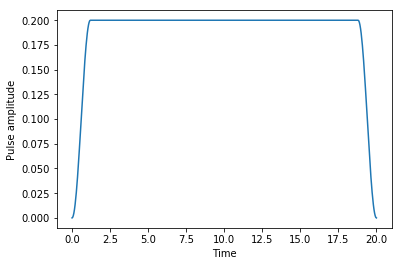

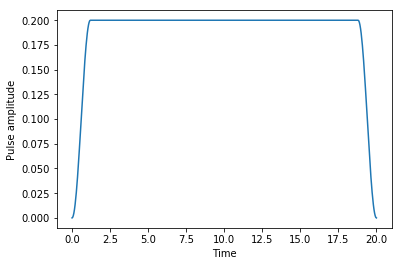

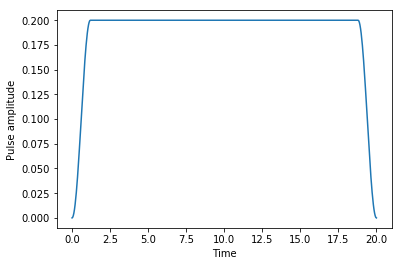

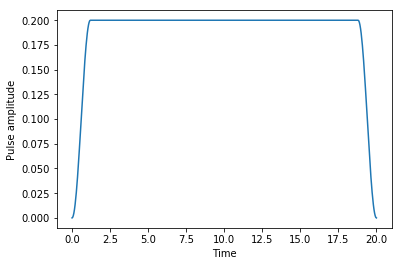

In [14]:
for H_i in H[1:]:
    plot_pulse(H_i[1], tlist)

The next line solves the equation of motion for the defined objective, which
contains the initial state $\ket{\Psi_{\init}}$ and the Hamiltonian $\op{H}(t)$
defining its evolution.

In [15]:
guess_dynamics = [ob.mesolve(tlist, progress_bar=True) for ob in objectives]

10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.22s. Est. time left: 00:00:00:00
30.0%. Run time:   0.29s. Est. time left: 00:00:00:00
40.0%. Run time:   0.35s. Est. time left: 00:00:00:00
50.0%. Run time:   0.43s. Est. time left: 00:00:00:00
60.0%. Run time:   0.52s. Est. time left: 00:00:00:00
70.0%. Run time:   0.58s. Est. time left: 00:00:00:00
80.0%. Run time:   0.63s. Est. time left: 00:00:00:00
90.0%. Run time:   0.69s. Est. time left: 00:00:00:00
Total run time:   0.94s
10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.30s. Est. time left: 00:00:00:01
30.0%. Run time:   0.41s. Est. time left: 00:00:00:00
40.0%. Run time:   0.52s. Est. time left: 00:00:00:00
50.0%. Run time:   0.69s. Est. time left: 00:00:00:00
60.0%. Run time:   0.80s. Est. time left: 00:00:00:00
70.0%. Run time:   0.92s. Est. time left: 00:00:00:00
80.0%. Run time:   1.05s. Est. time left: 00:00:00:00
90.0%. Run time:   1.21s. Est. time left: 00:00:00:00
Tota

The plot of the population dynamics shows that the guess field does not transfer
the initial state $\ket{\Psi_{\init}} = \ket{0}$ to the desired target state
$\ket{\Psi_{\tgt}} = \ket{1}$.

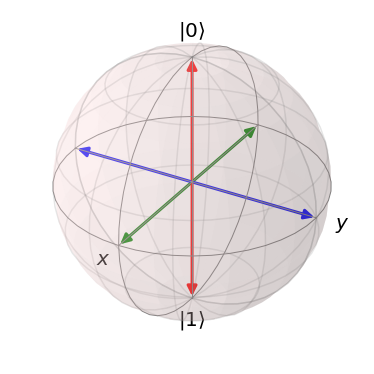

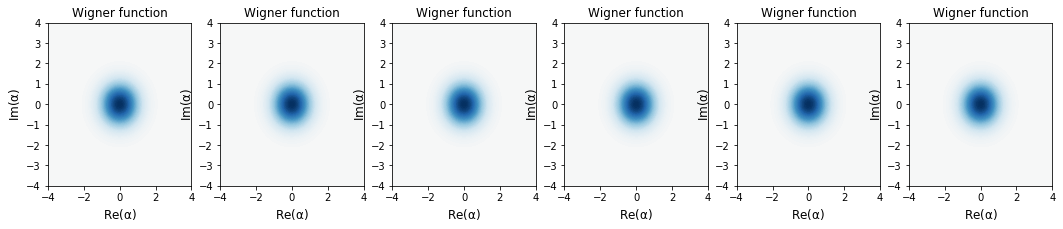

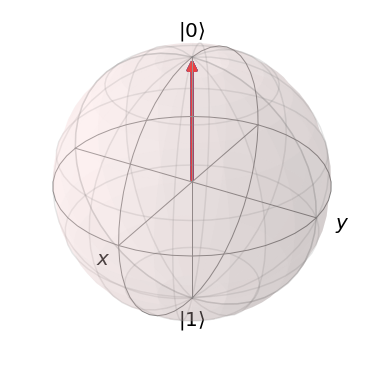

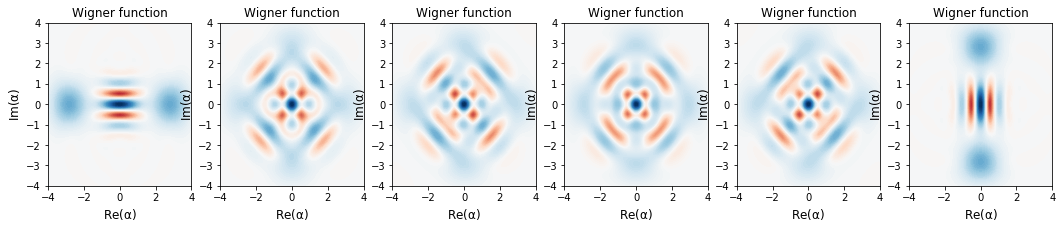

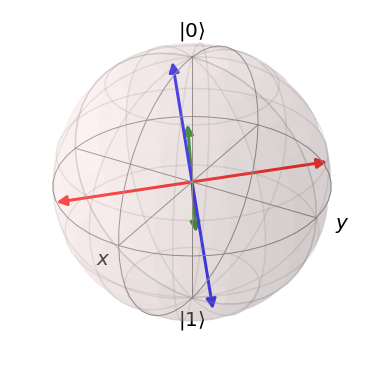

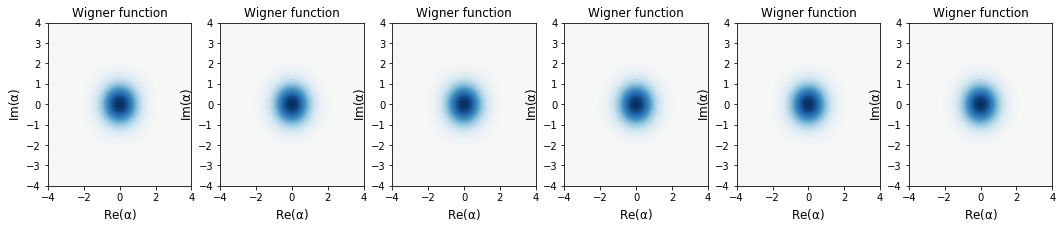

In [16]:
plot_all(guess_dynamics, ψ)

## Optimize

In the following we optimize the guess field $\epsilon_{0}(t)$ such
that the intended state-to-state transfer $\ket{\Psi_{\init}} \rightarrow
\ket{\Psi_{\tgt}}$ is solved.

The cell below carries out the optimization. It
requires, besides the
previously
defined optimization `objectives`, information
about the
optimization functional
$F$ (via `chi_constructor`) and the
propagation method that should be used. In
addition, the number of total
iterations is required and, as an option, we pass
an info-hook that after each
iteration combines a complete printout of the state
of the optimization with the
`print_fidelity` function defined above.

Here, we
choose $F = F_{re}$ with
\begin{equation}
F_{re}
=
\Re\Braket{\Psi(T)}{\Psi_{\tgt}}
\end{equation}

with
$\ket{\Psi(T)}$ the
forward propagated state of $\ket{\Psi_{\init}}$.

In [17]:
# Reset results
oct_result = None

In [18]:
iters = 10
if oct_result is not None:
    iters = oct_result.iters[-1] + iters

oct_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.chain(
        krotov.info_hooks.print_table(J_T=krotov.functionals.F_ss),
        print_fidelity
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-3, name='J_T'),
        krotov.convergence.delta_below(1e-5),
        #krotov.convergence.check_monotonic_error,
    ),
    #iter_stop=iters,
    continue_from = oct_result
)

  iter.        J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
      0   2.36e-02    0.00e+00   2.36e-02        n/a        n/a    13
    F = 0.10878137719682375
      1   3.54e-02    6.52e-02   1.01e-01   1.18e-02   7.69e-02    27 **
    F = 0.1745469614335434
      2   1.80e-01    2.28e-01   4.08e-01   1.45e-01   3.73e-01    34 **
    F = 0.3992181086270283
      3   2.28e-01    5.26e-02   2.81e-01   4.78e-02   1.00e-01    31 **
    F = 0.4517903261235843
      4   2.63e-01    4.45e-02   3.08e-01   3.53e-02   7.98e-02    29 **
    F = 0.49437200498611905
      5   3.76e-01    1.17e-01   4.92e-01   1.12e-01   2.29e-01    30 **
    F = 0.6095989046560172
      6   5.12e-01    1.05e-01   6.17e-01   1.36e-01   2.41e-01    29 **
    F = 0.7133170486790311
      7   6.44e-01    9.41e-02   7.38e-01   1.32e-01   2.26e-01    28 **
    F = 0.7996355050029568
      8   7.71e-01    8.51e-02   8.56e-01   1.27e-01   2.12e-01    27 **
    F = 0.8765954941568698
      9   8.40e-01    4.29e-02 

     82   9.97e-01    1.16e-03   9.99e-01   1.90e-04   1.35e-03    30 **
    F = 0.9986960278300034
     83   9.98e-01    1.18e-03   9.99e-01   1.70e-04   1.35e-03    33 **
    F = 0.9987816514383475
     84   9.98e-01    1.17e-03   9.99e-01   1.56e-04   1.32e-03    33 **
    F = 0.9988601516675941
     85   9.98e-01    1.11e-03   9.99e-01   1.41e-04   1.25e-03    30 **
    F = 0.998931063019377
     86   9.98e-01    1.03e-03   9.99e-01   1.26e-04   1.15e-03    35 **
    F = 0.9989941216662196
     87   9.98e-01    9.15e-04   9.99e-01   1.12e-04   1.03e-03    34 **
    F = 0.9990503644711507
     88   9.98e-01    7.95e-04   9.99e-01   1.02e-04   8.97e-04    35 **
    F = 0.9991015636780886
     89   9.98e-01    6.77e-04   9.99e-01   9.58e-05   7.72e-04    33 **
    F = 0.9991494252893715
     90   9.98e-01    5.68e-04   9.99e-01   9.16e-05   6.60e-04    32 **
    F = 0.9991951783822935
     91   9.98e-01    4.75e-04   9.99e-01   8.86e-05   5.63e-04    32 **
    F = 0.9992394692348192
 

In [19]:
oct_result

Krotov Optimization Result
--------------------------
- Started at 2019-03-25 13:57:44
- Number of objectives: 6
- Number of iterations: 128
- Reason for termination: Reached convergence: Δ(('info_vals', T[-1]),('info_vals', T[-2])) < 1e-05
- Ended at 2019-03-25 15:03:35

## Simulate dynamics of the optimized field

Having obtained the optimized
control field, we can now
plot it and calculate the
population dynamics under
this field.

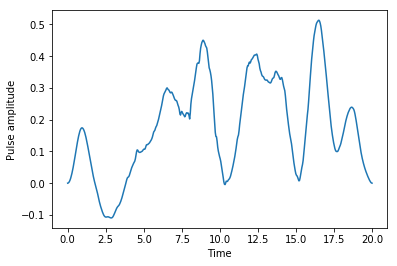

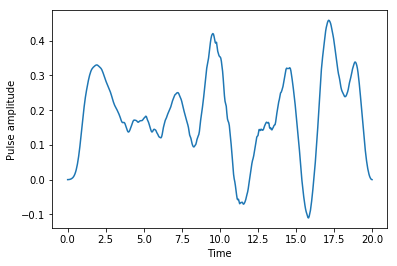

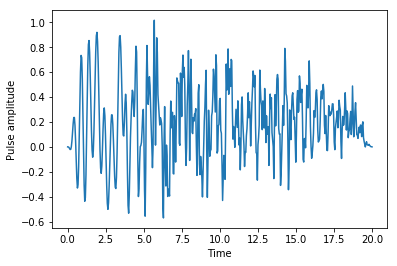

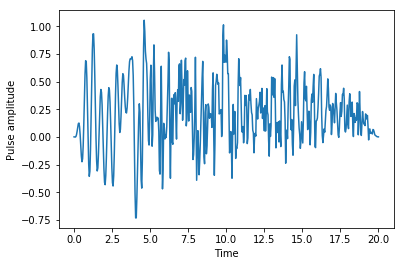

[None, None, None, None]

In [20]:
[plot_pulse(c, tlist) for c in oct_result.optimized_controls]

In contrast to the dynamics under the guess field, the optimized field indeed
drives the initial state $\ket{\Psi_{\init}} = \ket{0}$ to the desired target
state $\ket{\Psi_{\tgt}} = \ket{1}$.

In [21]:
opt_dynamics = [ob.mesolve(tlist, progress_bar=True) for ob in oct_result.optimized_objectives]

/home/wello/miniconda3/envs/qutip-env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/johan/Development/cat-state-encoding/Krotov/rhs4760.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


10.0%. Run time:   0.14s. Est. time left: 00:00:00:01
20.0%. Run time:   0.33s. Est. time left: 00:00:00:01
30.0%. Run time:   0.53s. Est. time left: 00:00:00:01
40.0%. Run time:   0.73s. Est. time left: 00:00:00:01
50.0%. Run time:   0.96s. Est. time left: 00:00:00:00
60.0%. Run time:   1.27s. Est. time left: 00:00:00:00
70.0%. Run time:   1.48s. Est. time left: 00:00:00:00
80.0%. Run time:   1.71s. Est. time left: 00:00:00:00
90.0%. Run time:   1.93s. Est. time left: 00:00:00:00
Total run time:   2.13s


/home/wello/miniconda3/envs/qutip-env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/johan/Development/cat-state-encoding/Krotov/rhs4761.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


10.0%. Run time:   0.11s. Est. time left: 00:00:00:01
20.0%. Run time:   0.23s. Est. time left: 00:00:00:00
30.0%. Run time:   0.39s. Est. time left: 00:00:00:00
40.0%. Run time:   0.58s. Est. time left: 00:00:00:00
50.0%. Run time:   0.79s. Est. time left: 00:00:00:00
60.0%. Run time:   1.00s. Est. time left: 00:00:00:00
70.0%. Run time:   1.21s. Est. time left: 00:00:00:00
80.0%. Run time:   1.41s. Est. time left: 00:00:00:00
90.0%. Run time:   1.61s. Est. time left: 00:00:00:00
Total run time:   1.80s


/home/wello/miniconda3/envs/qutip-env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/johan/Development/cat-state-encoding/Krotov/rhs4762.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


10.0%. Run time:   0.11s. Est. time left: 00:00:00:01
20.0%. Run time:   0.23s. Est. time left: 00:00:00:00
30.0%. Run time:   0.38s. Est. time left: 00:00:00:00
40.0%. Run time:   0.57s. Est. time left: 00:00:00:00
50.0%. Run time:   0.76s. Est. time left: 00:00:00:00
60.0%. Run time:   0.97s. Est. time left: 00:00:00:00
70.0%. Run time:   1.18s. Est. time left: 00:00:00:00
80.0%. Run time:   1.39s. Est. time left: 00:00:00:00
90.0%. Run time:   1.60s. Est. time left: 00:00:00:00
Total run time:   1.79s


/home/wello/miniconda3/envs/qutip-env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/johan/Development/cat-state-encoding/Krotov/rhs4763.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.31s. Est. time left: 00:00:00:01
30.0%. Run time:   0.46s. Est. time left: 00:00:00:01
40.0%. Run time:   0.75s. Est. time left: 00:00:00:01
50.0%. Run time:   1.01s. Est. time left: 00:00:00:01
60.0%. Run time:   1.23s. Est. time left: 00:00:00:00
70.0%. Run time:   1.52s. Est. time left: 00:00:00:00
80.0%. Run time:   1.74s. Est. time left: 00:00:00:00
90.0%. Run time:   1.99s. Est. time left: 00:00:00:00
Total run time:   2.17s


/home/wello/miniconda3/envs/qutip-env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/johan/Development/cat-state-encoding/Krotov/rhs4764.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


10.0%. Run time:   0.11s. Est. time left: 00:00:00:01
20.0%. Run time:   0.28s. Est. time left: 00:00:00:01
30.0%. Run time:   0.51s. Est. time left: 00:00:00:01
40.0%. Run time:   0.75s. Est. time left: 00:00:00:01
50.0%. Run time:   0.95s. Est. time left: 00:00:00:00
60.0%. Run time:   1.16s. Est. time left: 00:00:00:00
70.0%. Run time:   1.36s. Est. time left: 00:00:00:00
80.0%. Run time:   1.58s. Est. time left: 00:00:00:00
90.0%. Run time:   1.81s. Est. time left: 00:00:00:00
Total run time:   2.00s


/home/wello/miniconda3/envs/qutip-env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/johan/Development/cat-state-encoding/Krotov/rhs4765.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


10.0%. Run time:   0.13s. Est. time left: 00:00:00:01
20.0%. Run time:   0.31s. Est. time left: 00:00:00:01
30.0%. Run time:   0.50s. Est. time left: 00:00:00:01
40.0%. Run time:   0.75s. Est. time left: 00:00:00:01
50.0%. Run time:   0.96s. Est. time left: 00:00:00:00
60.0%. Run time:   1.16s. Est. time left: 00:00:00:00
70.0%. Run time:   1.36s. Est. time left: 00:00:00:00
80.0%. Run time:   1.58s. Est. time left: 00:00:00:00
90.0%. Run time:   1.79s. Est. time left: 00:00:00:00
Total run time:   1.98s


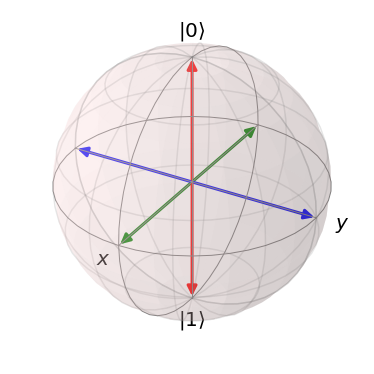

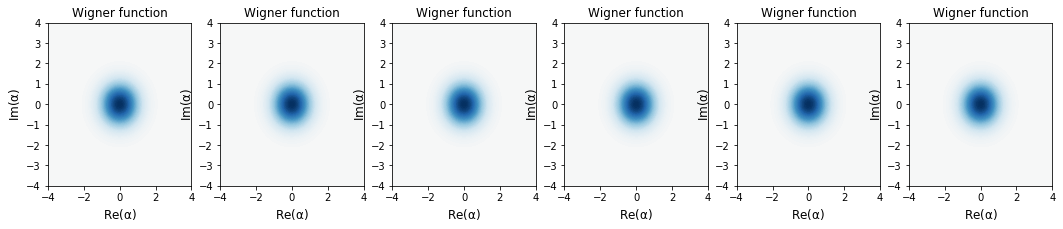

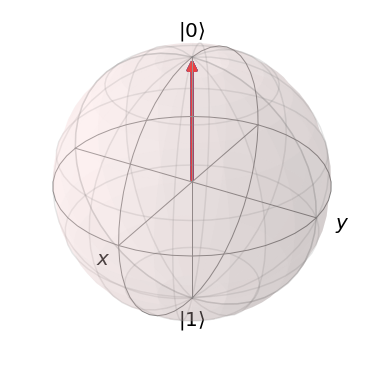

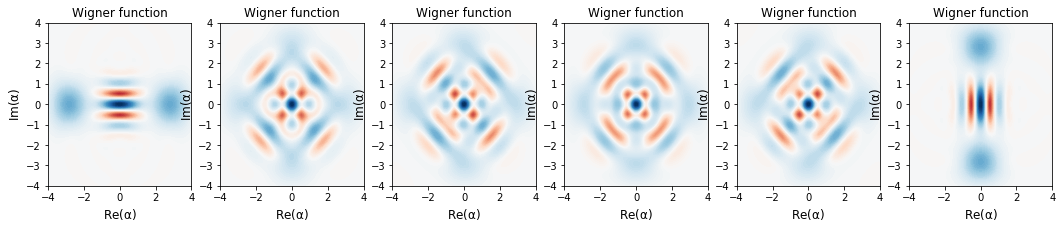

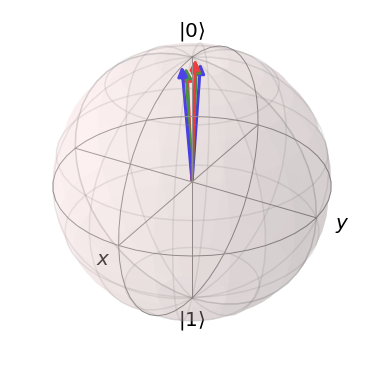

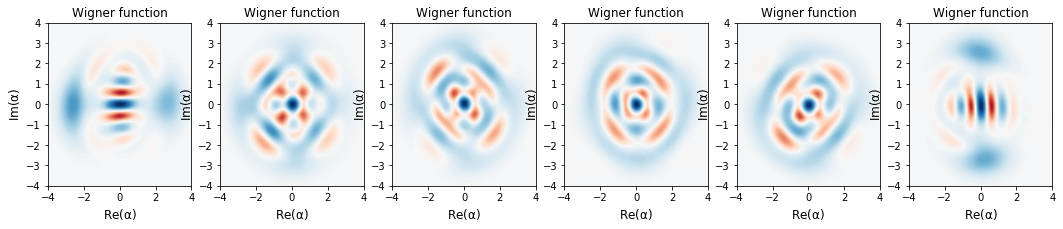

In [22]:
#print(fid(opt_dynamics, ψ[0][1]))
plot_all(opt_dynamics, ψ)